# Simulation of simple droplet model based on Brownian dynamics in ReaDDy framework

### Particle types: Droplet forming (y-motif), surface (DNA strand)

### Based on code used in: https://pubs.acs.org/doi/10.1021/acs.nanolett.3c01301



# Load important libraries

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import readdy
import math
import scipy
from scipy.optimize import curve_fit
'''from scipy.ndimage import gaussian_filter'''
from matplotlib.colors import LinearSegmentedColormap
import time
import scipy.integrate as integrate
print(readdy.__version__)
from scipy.spatial.transform import Rotation as Rot
'''from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure   
import matplotlib.gridspec as gridspec
from sklearn.cluster import DBSCAN
from sklearn import metrics'''
from collections import Counter
'''from jakteristics import compute_features'''
 
plt.rcParams['figure.dpi'] = 100

from multiprocessing import Process, Manager

2.0.12-1


# General functions

In [2]:
#generate n-component random vector with defined length
def randomvector(n,norm):
    #inputs:
    #n = dimension of vector
    #norm = length of vector
    
    #outputs:
    #v = vector
    
    components = [np.random.normal() for i in range(n)]
    r = math.sqrt(sum(x*x for x in components))
    v = [norm*x/r for x in components]
    return v

#generate coordinates inside spherical volume
def random_spherical_vol(n,r):
    #inputs:
    #n = number of 3D coordinates to generate
    #r = radius of sphere in witch vectors are
    
    #outputs:
    #coords_l = array of 3D coords
    
    i=0
    coords_l=[]
    while i<n:
        coords=np.random.random(size=(1, 3)) * 2*r - r
        coords_x= coords[0][0]
        coords_y= coords[0][1]
        coords_z= coords[0][2]
        if np.sqrt(coords_x**2+coords_y**2+coords_z**2)<r:
            i=i+1
            coords_l.append(coords[0])
    return np.asarray(coords_l)

#see https://readdy.github.io/system.html#potentials for potential parameters
def whi(r,k,h,d,r_c):
    y=[]
    for x in r:
        #print(x)
        if x<d:
            y_e= 1/2 * k * (x-d)**2 -h
        if d <= x < d+(r_c-d)/2:
            y_e= h/2 * ((r_c-d)/2)**-2 * (x-d)**2 -h
        if d+(r_c-d)/2 <= x < r_c:
            y_e= -h/2 * ((r_c-d)/2)**-2 * (x-r_c)**2
        if x>r_c:
            y_e=0
        y.append(y_e)
    return y


def har_rep(r,k_h,r_z):
    y=[]
    for x in r:
        if x<r_z:
            y_e= 1/2* k_h * (x-r_z)**2
        else:
            y_e=0
        y.append(y_e)
    return y



#run n functions in a list [f_1,...f_n] in parallel with parameters [[params_1],...,[params_n]]
def run_p(fcs,params):
    proc = []
    for i in range(len(fcs)):
        p = Process(target=fcs[i], args=(*params[i],))
        p.start()
        proc.append(p)
    for p in proc:
        p.join()
        
#run n functions  in a list [f_1,...f_n] in parallel with parameters [[params_1,return_dict],...,[params_n,return_dict]]
#add ouput in return_dict 
def run_p2(fcs,params):
    proc = []
    manager = Manager()
    return_dict = manager.dict()
    for i in range(len(fcs)):
        p = Process(target=fcs[i], args=(*params[i],return_dict))
        p.start()
        proc.append(p)
    for p in proc:
        p.join()   
    return return_dict


# Set units and temperature

In [3]:
custom_units = {'length_unit':'nanometer',
                'time_unit': 'nanoseconds',
                'energy_unit': 'joule'}
system_temperature=273.15 + 40  #293
kbt=system_temperature*1.380649*10**-23

# Particle types

In [4]:
#core particle
#tail particle
r_core=10
r_tail=20
r_bond=31

num_y=450 #comprises of one core particle
num_amph=0  #comprises of one core and one tail particle

#amph template

amph_pos_temp=np.asarray([(0,0,0),(r_bond,0,0)])
amph_type_temp=["core","tail"]
surface_types=["surface_repulsion", "surface_attraction"]
all_types=["core", "tail", "surface_repulsion", "surface_attraction"]

# Topology types

In [5]:
r_surface_attraction= r_core
r_surface_repulsion= r_core
num_surface= 1
num_repetition_of_surface = 10
template_surface_list= []

#list of types of monomers in polymer
for k in range(num_repetition_of_surface):
    for i in range(8):
        template_surface_list.append("surface_repulsion")

    for i in range(4):
        template_surface_list.append("surface_attraction")




#template surface
def surf_template_coords(n):

    surf_ini=[(0,0,0)]

    pos_list_r=np.zeros((len(template_surface_list),3))

    pos_list_r[0]=surf_ini[0]
    norm_v=n 
    m=0

    while m < len(template_surface_list)-1: 
        pos_e=randomvector(3,norm_v) + pos_list_r[m] 

        pos_val=True
        for l in range(m-1):
            if np.sqrt ( (pos_e[0] - pos_list_r[l][0])**2 + (pos_e[1] -pos_list_r[l][1])**2 + (pos_e[2] - pos_list_r[l][2])**2) < norm_v:
                pos_val=False
                break
                
        if pos_val==True:
            pos_list_r[m+1]=np.asarray(pos_e)
            m=m+1

    return pos_list_r



        

# Interaction potentials

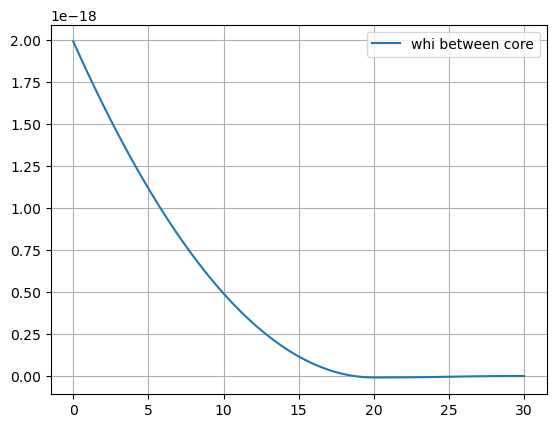

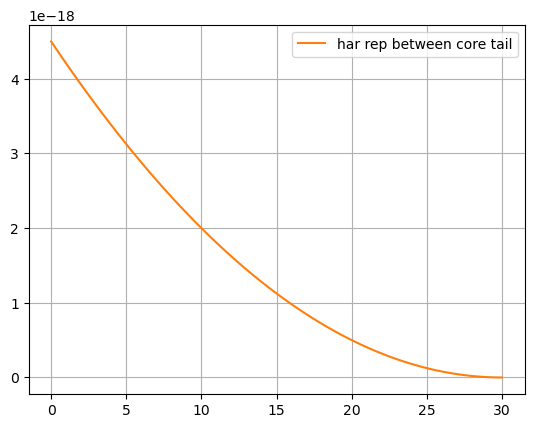

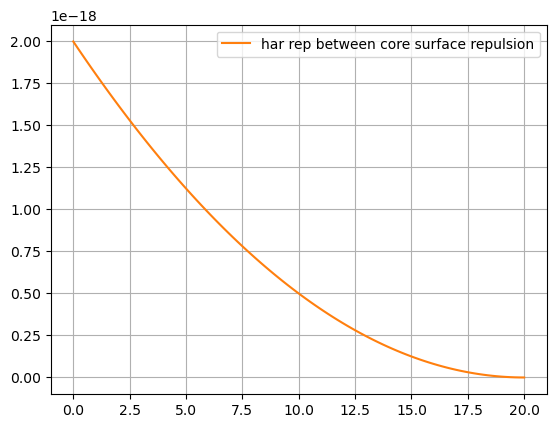

In [6]:
#whi int between core particles
k_whi=1*10**-20 #repulsion
h_whi=2*kbt #attraction
d_whi=2*r_core
r_c_whi=3*r_core

whi_x=np.linspace(0,r_c_whi,100)
whi_y=whi(r=whi_x,k=k_whi,h=h_whi,d=d_whi,r_c=r_c_whi)
plt.errorbar(whi_x,whi_y,label="whi between core")
plt.grid()
plt.legend()
plt.show()

#har rep interaction between core tail particles
k_har_rep=1*10**-20
r_z_har_rep=r_core+r_tail

har_rep_x=np.linspace(0,r_z_har_rep,100)
har_rep_y=har_rep(r=har_rep_x,k_h=k_har_rep,r_z=r_z_har_rep)
plt.errorbar(har_rep_x,har_rep_y,label="har rep between core tail",color="tab:orange")
plt.grid()
plt.legend()
plt.show()

#har rep interaction between core surface_repulsion particles
k_har_rep=1*10**-20
r_z_har_rep_surf=r_core+r_surface_attraction

har_rep_x2=np.linspace(0,r_z_har_rep_surf,100)
har_rep_y2=har_rep(r=har_rep_x2,k_h=k_har_rep,r_z=r_z_har_rep_surf)
plt.errorbar(har_rep_x2,har_rep_y2,label="har rep between core surface repulsion",color="tab:orange")
plt.grid()
plt.legend()
plt.show()

# Bond parameters

In [7]:
k_bb_link=10**-20  

eq_dist_bb=r_bond

# Diffusion constant


In [8]:
#viscosity at certain temperature
#Kestin, J., Sokolov, M., & Wakeham, W. A. (1978). Viscosity of liquid water in the range− 8 C to 150 C. Journal of physical and chemical reference data, 7(3), 941-948.
#see https://srd.nist.gov/jpcrdreprint/1.555581.pdf
def visc_T(T_in):
    T=T_in-273.15
    mu_0=1002.0 *10**-6
    mu_T=mu_0 * 10**( (20-T)/(T+96) * (1.2387 - 1.303*10**-3 * (20-T) + 3.06*10**-6 * (20-T)**2 + 2.55*10**-8 * (20-T)**3 ) )
    
    return mu_T  #Pa*s
    
    
visc_T_sys=visc_T(system_temperature)
    
#Diffusion const. 
#Einstein relation
def Diff_ES(T,r,eta):
    D=T*1.380649*10**-23 /(6*np.pi*eta*r)
    return D   #m^2/s
Diff_core=Diff_ES(system_temperature,r_core*10**-9,visc_T_sys) *10**9

Diff_tail=Diff_ES(system_temperature,r_tail*10**-9,visc_T_sys) *10**9

Diff_attraction=Diff_ES(system_temperature,r_surface_attraction*10**-9,visc_T_sys) *10**9
Diff_repulsion=Diff_ES(system_temperature,r_surface_repulsion*10**-9,visc_T_sys) *10**9

print("Diff_core=",Diff_core)

print("Diff_tail",Diff_tail)

print("Diff_attraction=",Diff_attraction)

print("Diff_repulsion",Diff_repulsion)

Diff_core= 0.03514074558690859
Diff_tail 0.017570372793454296
Diff_attraction= 0.03514074558690859
Diff_repulsion 0.03514074558690859


In [9]:
#integration time step
t_step=500*10**-3



In [10]:
print("radius core=",r_core)
print("radius tail=", r_tail)
print("distance bond amph=", r_bond)
print("#############")
print("number y particles=",num_y)
print("number amph particles=", num_amph)
print("#############")
print("k whi potential=",k_whi)
print("depht whi potential=",h_whi)
print("min dist whi potential=",d_whi)
print("cutoff whi potential=",r_c_whi)
print("#############")
print("k hr=", k_har_rep)
print("cutoff har rep=", r_z_har_rep)
print("#############")
print("k bond in amph=", k_bb_link)
print("eq dist bond in amph=", eq_dist_bb)
print("#############")
print("Diff const core=",Diff_core)
print("Diff const tail=",Diff_tail)
print("#############")
print("t step =",t_step)

radius core= 10
radius tail= 20
distance bond amph= 31
#############
number y particles= 450
number amph particles= 0
#############
k whi potential= 1e-20
depht whi potential= 8.647004687e-21
min dist whi potential= 20
cutoff whi potential= 30
#############
k hr= 1e-20
cutoff har rep= 30
#############
k bond in amph= 1e-20
eq dist bond in amph= 31
#############
Diff const core= 0.03514074558690859
Diff const tail= 0.017570372793454296
#############
t step = 0.5


In [11]:

#set up and run simulation
def sim_min_model_6(gen,add_num,restart_checkpoint=False,make_checkpoint=False):
    #inputs:
    #gen = number of times to repeate same sim (set to 1)
    #add_num = numerical identifier
    #restart_checkpoint, make_checkpoint = whether to make and restart from simulation checkpoint, sometimes causes problems
    
    
    for gen_t in range(gen):
        
        #len_pol=num_mon
        folder="/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/"
        
        #initialize system5
        system = readdy.ReactionDiffusionSystem(box_size=[1000,1000,1000],unit_system=custom_units)
        system.periodic_boundary_conditions = False, False, False
        system.temperature=system_temperature

        system.topologies.add_type("Particle")
        system.topologies.add_type("Surface")
        
        
        print(system.box_size.magnitude)
        #radius of confinement
        r_sp=30
        
        #spring constant for confinement
        #k_sp=500*10**-24 
        k_sp=0.01 *10**-19
        
        #box potential dimensions
        box_a=-400
        box_b=800
        #k_box=5*10**-24 
        k_box=1*10**-20

        
        #basic parameters and potentials
        #add linker type 1
        for i in all_types:
            if i=="core":
                D_m=Diff_core
            if i=="tail":
                D_m=Diff_tail
            if i=="surface_attraction":
                D_m=Diff_attraction
            if i=="surface_repulsion":
                D_m=Diff_repulsion
            
            
            system.add_topology_species(i,D_m)
            #spherical inclusion
            #system.potentials.add_sphere(i,k_sp,[0, 0, 0], r_sp,True)
            
            #box potential
            system.potentials.add_box(i, k_box, [box_a, box_a, box_a],[box_b, box_b, box_b])


        #add harmonic repulsion between tail and core

        system.potentials.add_harmonic_repulsion("tail", "core", force_constant=k_har_rep, interaction_distance=r_z_har_rep)
        
        #add attraction between core
        system.potentials.add_weak_interaction_piecewise_harmonic("core","core",force_constant=k_whi, desired_distance=d_whi, depth=h_whi, cutoff=r_c_whi)
 
        #add bond between core and tail for amph particle
        system.topologies.configure_harmonic_bond("core", "tail", force_constant=k_bb_link, length=eq_dist_bb)

        #harmonic repulsion for topology
        system.potentials.add_harmonic_repulsion("surface_attraction", "surface_repulsion", force_constant=k_har_rep, interaction_distance=r_surface_attraction)
        system.potentials.add_harmonic_repulsion("surface_attraction", "surface_attraction", force_constant=k_har_rep, interaction_distance=r_surface_attraction)
        system.potentials.add_harmonic_repulsion("surface_repulsion", "surface_repulsion", force_constant=k_har_rep, interaction_distance=r_surface_attraction)

        #Topology
        #bond between topology surface
        system.topologies.configure_harmonic_bond("surface_attraction","surface_repulsion", force_constant=k_bb_link, length=r_surface_attraction)

        #bond between topology surface
        system.topologies.configure_harmonic_bond("surface_attraction","surface_attraction", force_constant=k_bb_link, length=r_surface_attraction)

        #bond between topology surface
        system.topologies.configure_harmonic_bond("surface_repulsion","surface_repulsion", force_constant=k_bb_link, length=r_surface_attraction)
        
        #attraction of surface_attraction and core
        system.potentials.add_weak_interaction_piecewise_harmonic("surface_attraction","core",force_constant=k_whi, desired_distance=d_whi, depth=h_whi, cutoff=r_c_whi)
        #repulsion of surface_repulsion and core
        system.potentials.add_harmonic_repulsion("surface_repulsion", "core", force_constant=k_har_rep, interaction_distance=r_z_har_rep_surf)

        ## repulsion between tail and repulsion/attraction
        system.potentials.add_harmonic_repulsion("tail", "surface_attraction", force_constant=k_har_rep, interaction_distance=r_z_har_rep)
        system.potentials.add_harmonic_repulsion("tail", "surface_repulsion", force_constant=k_har_rep, interaction_distance=r_z_har_rep)

        
        ### harmonic angle

        #system.topologies.configure_harmonic_angle("surface_attraction","surface_attraction","surface_repulsion",force_constant=10**-19,equilibrium_angle=np.pi)
        #system.topologies.configure_harmonic_angle("surface_attraction","surface_attraction","surface_attraction",force_constant=10**-19,equilibrium_angle=np.pi)
        #system.topologies.configure_harmonic_angle("surface_repulsion","surface_repulsion","surface_repulsion",force_constant=10**-19,equilibrium_angle=np.pi)
        #system.topologies.configure_harmonic_angle("surface_repulsion","surface_repulsion","surface_attraction",force_constant=10**-19,equilibrium_angle=np.pi)

        for i in range(len(surface_types)):
            for j in range(i+1):
                for k in range(j+1):
                    t1=surface_types[i]
                    t2=surface_types[j]
                    t3=surface_types[k]
                    system.topologies.configure_harmonic_angle(t1,t2,t3,force_constant=10**-19,equilibrium_angle=np.pi)

        
        simulation = system.simulation(kernel="SingleCPU")
        #simulation = system.simulation(kernel="CPU")
        #simulation.kernel_configuration.n_threads = 2
        #simulation.reaction_handler = "UncontrolledApproximation"


        #add particles if no restart from checkpoint
        if restart_checkpoint==False:
            if num_y>0:
                #add y particles
                #pos_y=np.random.uniform(size=(num_y,3)) * system.box_size.magnitude*0.8 - system.box_size.magnitude*0.8 * 0.5
                #pos_y=np.random.uniform(size=(num_y,3)) *  np.asarray([350.,350.,350.]) *0.8 -  np.asarray([350.,350.,350.])*0.8 * 0.5
                pos_y=random_spherical_vol(num_y,200)

                simulation.add_particles("core", pos_y)

            
            #add amph particles
            for i in range(num_amph):
                #ini_amph=np.random.uniform(size=(1,3)) * system.box_size.magnitude*0.8 - system.box_size.magnitude*0.8 * 0.5
                #ini_amph=np.random.uniform(size=(1,3)) * np.asarray([350.,350.,350.]) *0.8 -  np.asarray([350.,350.,350.]) *0.8 * 0.5
                
                ini_amph=random_spherical_vol(1,200)
                pos_amph_list=[]
                Rot_1=Rot.random()
                for m in range(len(amph_pos_temp)):
                    pos_amph_list.append(*(Rot_1.apply(amph_pos_temp[m]) + ini_amph))
                   
                pos_amph_list=np.asarray(pos_amph_list)
                
                amph_particle=simulation.add_topology("Particle",amph_type_temp,pos_amph_list)
                amph_particle.get_graph().add_edge(0, 1)

            #surface
            for i in range(num_surface):

                surf_1_ini=[(0,0,0)]
                pos_list_surf=surf_template_coords(r_surface_attraction) + np.asarray(surf_1_ini)

                pol=simulation.add_topology("Surface",template_surface_list,pos_list_surf)

                for k in range (len(template_surface_list)-1):
                    pol.get_graph().add_edge(k,k+1)

        
        #load particle config from checkpoint
        #if restart_checkpoint==True:
            #simulation.load_particles_from_latest_checkpoint("files_effective_droplet_1/checkpoints_1/")
            
            #simulation.load_particles_from_checkpoint("files_1_surface_condensation_cluster_formation_4/checkpoints_txx/x_shaped_particle_test_847_checkpoint_200000.h5")
            
        if make_checkpoint==True:
            
            simulation.make_checkpoints(stride=1500, output_directory="/home/aaron/phd/files_effective_droplet_1/checkpoints_1/", max_n_saves=1)
                     
        dt_rec=1500            
        output_file_name=folder+"effective_droplet_"+str(int(gen_t)+int(add_num))+".h5"
        simulation.output_file = output_file_name
        simulation.record_trajectory(dt_rec)        
        simulation.observe.particles(dt_rec)
        simulation.observe.energy(stride=dt_rec)
        simulation.observe.topologies(dt_rec)
        simulation.observe.reaction_counts(dt_rec)
        simulation.observe.number_of_particles(stride=dt_rec,types=["core","tail"])

        
        simulation.progress_output_stride = 1

        simulation.evaluate_topology_reactions = False
        simulation.evaluate_reactions = False
        
        #simulation.skin = 1
        
        
        simulation.run(5000000, t_step )




# Run simulations

In [18]:
%%time

test1=sim_min_model_6(gen=1,add_num=666,restart_checkpoint=False,make_checkpoint=False)

#test1=sim_min_model_7(gen=1,add_num=700,restart_file="/home/aaron/phd/files_effective_droplet_1/test_runs_1/effective_droplet_1400.h5",restart_checkpoint=False,make_checkpoint=False)
    
#test1=sim_min_model_8(gen=1,add_num=999,restart_file="/home/aaron/phd/files_effective_droplet_1/runs_dispersal_1/effective_droplet_125019.h5",restart_checkpoint=False,make_checkpoint=False)
    

[1000. 1000. 1000.]
Configured kernel context with:
--------------------------------
 - kBT = 4.3235023435e-21
 - periodic b.c. = (false, false, false)
 - box size = (1000, 1000, 1000)
 - particle types:
     * Topology particle type "surface_attraction" with D=0.03514074558690859
     * Topology particle type "surface_repulsion" with D=0.03514074558690859
     * Topology particle type "tail" with D=0.017570372793454296
     * Topology particle type "core" with D=0.03514074558690859
 - potentials of order 1:
     * for type "surface_attraction"
         * Harmonic Box inclusion potential with force constant 1e-20 and parameters minimum vertex v0=(-400,-400,-400) and maximum vertex v1=(400,400,400).
     * for type "surface_repulsion"
         * Harmonic Box inclusion potential with force constant 1e-20 and parameters minimum vertex v0=(-400,-400,-400) and maximum vertex v1=(400,400,400).
     * for type "tail"
         * Harmonic Box inclusion potential with force constant 1e-20 and pa

  0%|                                                                          | 8110/5000000 [00:04<42:27, 1959.50it/s]


KeyboardInterrupt: 

# Run multiple simulations in parallel

In [62]:
sims_gen=1
sims_add_num=[51108,51109] #,51108,51109]
sim_col=[]
sim_param_col=[]
for i in range(len(sims_add_num)):
    sim_col.append(sim_min_model_6)
    sim_param_col.append([1,sims_add_num[i],False,False])
    
print(sim_col)
print(sim_param_col)

[<function sim_min_model_6 at 0x7f7a61349a60>, <function sim_min_model_6 at 0x7f7a61349a60>]
[[1, 51108, False, False], [1, 51109, False, False]]


In [63]:
run_p(sim_col,sim_param_col)

[1000. 1000. 1000.][1000. 1000. 1000.]

Configured kernel context with:
--------------------------------
 - kBT = 4.3235023435e-21
 - periodic b.c. = (false, false, false)
 - box size = (1000, 1000, 1000)
 - particle types:
     * Topology particle type "surface_attraction" with D=0.03514074558690859
     * Topology particle type "surface_repulsion" with D=0.03514074558690859
     * Topology particle type "tail" with D=0.017570372793454296
     * Topology particle type "core" with D=0.03514074558690859
 - potentials of order 1:
     * for type "surface_attraction"
         * Harmonic Box inclusion potential with force constant 1e-20 and parameters minimum vertex v0=(-400,-400,-400) and maximum vertex v1=(400,400,400).
     * for type "surface_repulsion"
         * Harmonic Box inclusion potential with force constant 1e-20 and parameters minimum vertex v0=(-400,-400,-400) and maximum vertex v1=(400,400,400).
     * for type "tail"
         * Harmonic Box inclusion potential with force c

100%|███████████████████████████████████████████████████████████████████████| 5000000/5000000 [30:38<00:00, 2719.35it/s]


# Load and evaluate simulation

In [20]:
#load saved config
traj=readdy.Trajectory("/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5601.h5")

times,types,ids,part_positions=traj.read_observable_particles()

#part_pos_eq=part_positions
time_e, energy=traj.read_observable_energy()

In [15]:
radii={}
for i in range(len(all_types)):
    sel=all_types[i]
    if sel=="core":
        radii[all_types[i]]=r_core
    if sel=="tail":
        radii[all_types[i]]=r_tail

    if sel=="surface_attraction":
        radii[all_types[i]]=r_surface_attraction

    if sel=="surface_repulsion":
        radii[all_types[i]]=r_surface_repulsion

In [25]:
#convert to trajectory for visualization (e.g. VMD)
traj.convert_to_xyz(particle_radii=radii)

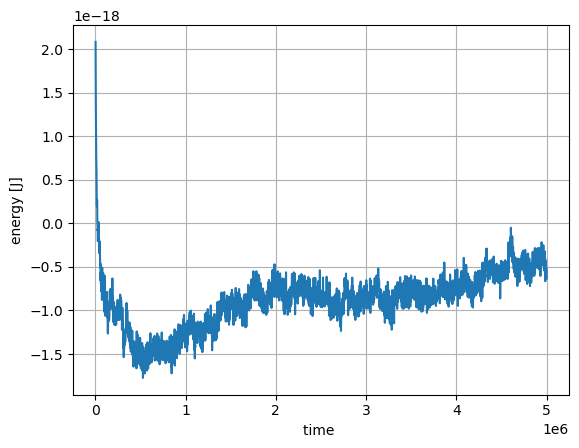

In [21]:
#plt.figure(figsize=(8,6))
plt.plot(time_e[2:],energy[2:])
plt.ylabel("energy [J]")
plt.xlabel("time ")
plt.grid()

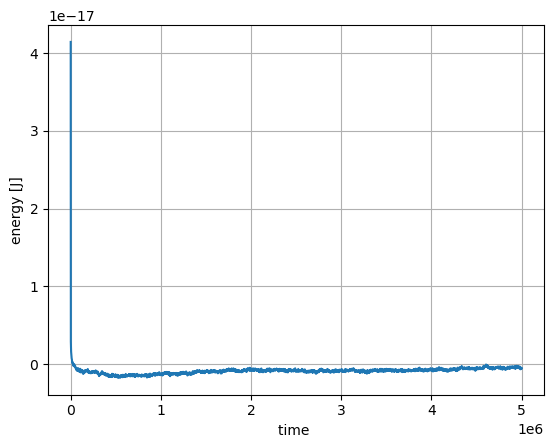

In [22]:
#plt.figure(figsize=(8,6))
plt.plot(time_e[:],energy[:])
plt.ylabel("energy [J]")
plt.xlabel("time ")
plt.grid()